<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/master/notebooks/languageXplay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install package dependencies (forces restart)
import os

def restart_runtime():
    print('Runtime restarting...')
    os.kill(os.getpid(), 9)
    
!git clone 'https://github.com/sholtodouglas/pandaRL' 'local_packages/pandaRL'
!pip install -e 'local_packages/pandaRL/.'

restart_runtime()

In [1]:
!pip -q install pybullet wandb

     |████████████████████████████████| 76.6MB 70kB/s 
     |████████████████████████████████| 1.9MB 66.5MB/s 
     |████████████████████████████████| 102kB 11.1MB/s 
     |████████████████████████████████| 102kB 13.0MB/s 
     |████████████████████████████████| 163kB 64.6MB/s 
     |████████████████████████████████| 133kB 62.9MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 


In [2]:
# Config
config = {
    'colab':True,
    'gcs':False,
    'device':'TPU', # 'CPU', 'GPU', 'TPU'
    'train_datasets':["UR5", "UR5_slow_gripper","UR5_high_transition"],
    'test_datasets':["UR5_slow_gripper_test"],
    # data
    'batch_size':32,
    # model
    'layer_size':256,
    'latent_dim':256,
    'gcbc':False,
    'num_distribs':None,
    'qbits':None,
    # training
    'learning_rate':3e-4,
}

In [77]:
#@title Workpace Setup (Local vs Colab)
from pathlib import Path
import os

# COLAB = False #@param {type:"boolean"}
AUTH_GCS = False #@param {type:"boolean"}
# DEVICE = "CPU" #@param ["TPU", "GPU", "CPU"]
DATA_SOURCE = "Google Drive" #@param ["Google Drive", "GCS"]
# TRAIN_DATASETS = ["UR5"]#,"UR5_slow_gripper","UR5_high_transition"]
# TEST_DATASET = "UR5_slow_gripper_test" #@param ["UR5_slow_gripper_test"]
GCS_USER = "sholto" #@param ["sholto", "tristan"]

if config['colab']:
    from google.colab import drive, auth
    print('Using colab setup')
    !git clone 'https://github.com/sholtodouglas/learning_from_play'
    WORKING_PATH = Path('/content/learning_from_play')
    drive.mount('/content/drive')
    os.chdir(WORKING_PATH)
    STORAGE_PATH = Path('/content/drive/My Drive/Robotic Learning')
    print(f'Storage path: {STORAGE_PATH}')
else:
    print('Using local setup')
    WORKING_PATH = Path().absolute().parent
    print(f'Working path: {WORKING_PATH}')
    os.chdir(WORKING_PATH)
    STORAGE_PATH = WORKING_PATH
    print(f'Storage path: {STORAGE_PATH}')



Using colab setup
fatal: destination path 'learning_from_play' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Storage path: /content/drive/My Drive/Robotic Learning


In [78]:
if DATA_SOURCE == "Google Drive":
  TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in config['train_datasets']]
  TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in config['test_datasets']]
elif DATA_SOURCE == "GCS":
  project_id = 'learning-from-play-303306'
  bucket_name = 'lfp_iowa_bucket'
  from google.colab import auth
  auth.authenticate_user()
  TRAIN_DATA_PATHS = get_tf_records(config['train_datasets'], bucket_name)
  VALID_DATA_PATHS = get_tf_records(config['test_datasets'], bucket_name)
  

In [69]:
!curl ipinfo.io # if this isn't in Iowa our bucket will have a bad time, make one in the same region and retransfer the data using the notebook included in the repo

{
  "ip": "104.154.177.101",
  "hostname": "101.177.154.104.bc.googleusercontent.com",
  "city": "Council Bluffs",
  "region": "Iowa",
  "country": "US",
  "loc": "41.2619,-95.8608",
  "org": "AS15169 Google LLC",
  "postal": "51502",
  "timezone": "America/Chicago",
  "readme": "https://ipinfo.io/missingauth"
}

# Data Creation

In [70]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

if config['device'] == "TPU":
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    NUM_DEVICES = strategy.num_replicas_in_sync
    print("REPLICAS: ", NUM_DEVICES)
else:
    physical_devices = tf.config.list_physical_devices()
    if config['device'] == 'GPU':
        tf.config.experimental.set_memory_growth(physical_devices[3], enable=True)
    NUM_DEVICES = 1
    print(physical_devices)

Tensorflow version 2.4.1
Running on TPU  ['10.56.46.242:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.56.46.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.56.46.242:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Dataset

In [71]:
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
from collections import Counter
import random
import datetime

import lfp
from natsort import natsorted

In [72]:
# Use this to edit modules without needing to restart the kernel
import importlib
importlib.reload(lfp.data)
importlib.reload(lfp.model)
importlib.reload(lfp.train)


<module 'lfp.train' from '/content/learning_from_play/lfp/train.py'>

### Config Flags

In [79]:
GLOBAL_BATCH_SIZE = config['batch_size'] * NUM_DEVICES
dl = lfp.data.PlayDataloader(batch_size=GLOBAL_BATCH_SIZE)

In [80]:
from_tfrecords = False

In [81]:
# Train data
# Hey Tristan, I got everything else but I'm a bit tired and want an elegant way to do this
# basically I have a function which gets the tf record paths in GCS (you'll see it at the top of data)
# but too tired to work out how to get that elegantly into the flow with the option of local files, don't want to get too fucked with ifs
train_data = dl.extract(TRAIN_DATA_PATHS, from_tfrecords=from_tfrecords)
train_dataset = dl.load(train_data)

UR5_high_transition: 100%|██████████| 32/32 [00:00<00:00, 46.84it/s]


{   'acts': TensorSpec(shape=(256, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(256, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(256, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(256, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(256, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(256,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(256, None, 1), dtype=tf.int32, name=None)}


In [82]:
# Validation data
valid_data = dl.extract(TEST_DATA_PATHS, from_tfrecords=from_tfrecords)
valid_dataset = dl.load(valid_data)

UR5_slow_gripper_test: 100%|██████████| 2/2 [00:00<00:00, 52.29it/s]

{   'acts': TensorSpec(shape=(256, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(256, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(256, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(256, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(256, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(256,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(256, None, 1), dtype=tf.int32, name=None)}


# Model

# Training Loop

In [83]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import Progbar
import tensorflow_addons as tfa
import tensorflow_probability as tfp
tfd = tfp.distributions

import time
import io
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [84]:
from lfp.metric import MaxMetric, create_metrics, record, log_action_breakdown
from lfp.train import LFPTrainer

In [85]:
def train_setup():
    model_params = {'obs_dim':dl.obs_dim,
                'goal_dim':dl.goal_dim,
                'act_dim':dl.act_dim,
                'layer_size':config['layer_size'], 
                'latent_dim':config['latent_dim']}
    
    actor = lfp.model.create_actor(**model_params, gcbc=config['gcbc'], num_distribs=config['num_distribs'])

    if config['gcbc']:
        encoder = None
        planner = None
    else:
        encoder = lfp.model.create_encoder(**model_params)
        planner = lfp.model.create_planner(**model_params)

    optimizer = tf.optimizers.Adam(learning_rate=config['learning_rate'])
    trainable_variables = actor.trainable_variables + encoder.trainable_variables + planner.trainable_variables
    return actor, encoder, planner, optimizer, trainable_variables

if config['device']=='CPU':
    actor, encoder, planner, optimizer, trainable_variables = train_setup()
else:
    with strategy.scope():
        actor, encoder, planner, optimizer, trainable_variables = train_setup()
        
train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_dataset))
valid_dist_dataset = iter(strategy.experimental_distribute_dataset(valid_dataset))

In [86]:
with strategy.scope():
    nll_action_loss = lambda y, p_y: tf.reduce_sum(-p_y.log_prob(y), axis=2)
    mae_action_loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
    mse_action_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

    def compute_loss(labels, predictions, mask, seq_lens, weightings=None):
        if config['num_distribs'] is not None:
            per_example_loss = nll_action_loss(labels, predictions) * mask
        else:
            per_example_loss = mae_action_loss(labels, predictions) * mask

        per_example_loss = tf.reduce_sum(per_example_loss, axis=1) / seq_lens  # take mean along the timestep
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)


    def compute_MAE(labels, predictions, mask, seq_lens, weightings=None):
        per_example_loss = mae_action_loss(labels, predictions) * mask
        per_example_loss = tf.reduce_sum(per_example_loss, axis=1) / seq_lens  # take mean along the timestep
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)


    def compute_regularisation_loss(plan, encoding):
        # Reverse KL(enc|plan): we want planner to map to encoder (weighted by encoder)
        reg_loss = tfd.kl_divergence(encoding, plan)  # + KL(plan, encoding)
        return tf.nn.compute_average_loss(reg_loss, global_batch_size=GLOBAL_BATCH_SIZE)

    train_loss, valid_loss, actor_grad_norm, encoder_grad_norm, planner_grad_norm, \
    actor_grad_norm_clipped, encoder_grad_norm_clipped, planner_grad_norm_clipped, global_grad_norm, \
    test, test2,  train_act_with_enc_loss, train_act_with_plan_loss, valid_act_with_enc_loss, valid_act_with_plan_loss,\
    train_reg_loss, valid_reg_loss, valid_position_loss,  valid_max_position_loss, valid_rotation_loss, valid_max_rotation_loss, valid_gripper_loss = create_metrics()


# Now outside strategy .scope
def train_step(inputs, beta, prev_global_grad_norm):
    with tf.GradientTape() as actor_tape, tf.GradientTape() as encoder_tape, tf.GradientTape() as planner_tape:  # separate tapes to simplify grad_norm logging and clipping for stability
        # Todo: figure out mask and seq_lens for new dataset 
        states, actions, goals, seq_lens, mask = inputs['obs'], inputs['acts'], inputs['goals'], inputs['seq_lens'], \
                                                 inputs['masks']

        if config['gcbc']:
            distrib = actor([states, goals])
            loss = compute_loss(actions, distrib, mask, seq_lens)
            gradients = tape.gradient(loss, actor.trainable_variables)
            optimizer.apply_gradients(zip(gradients, actor.trainable_variables))
        else:
            encoding = encoder([states, actions])
            plan = planner([states[:, 0, :], goals[:, 0,:]])  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 
            z_enc = encoding.sample()
            z_plan = plan.sample()
            z_enc_tiled = tf.tile(tf.expand_dims(z_enc, 1), (1, dl.window_size, 1))
            z_plan_tiled = tf.tile(tf.expand_dims(z_plan, 1), (1, dl.window_size, 1))

            enc_policy = actor([states, z_enc_tiled, goals])
            plan_policy = actor([states, z_plan_tiled, goals])

            act_enc_loss = record(compute_loss(actions, enc_policy, mask, seq_lens), train_act_with_enc_loss)
            act_plan_loss = record(compute_loss(actions, plan_policy, mask, seq_lens), train_act_with_plan_loss)
            reg_loss = record(compute_regularisation_loss(plan, encoding), train_reg_loss)
            loss = act_enc_loss + reg_loss * beta

            actor_gradients = actor_tape.gradient(loss, actor.trainable_variables)
            encoder_gradients = encoder_tape.gradient(loss, encoder.trainable_variables)
            planner_gradients = planner_tape.gradient(loss, planner.trainable_variables)

            actor_norm = record(tf.linalg.global_norm(actor_gradients), actor_grad_norm)
            encoder_norm = record(tf.linalg.global_norm(encoder_gradients), encoder_grad_norm)
            planner_norm = record(tf.linalg.global_norm(planner_gradients), planner_grad_norm)

            gradients = actor_gradients + encoder_gradients+planner_gradients

            # if the gradient norm is more than 3x the previous one, clip it to the previous norm for stability
            gradients = tf.cond(tf.linalg.global_norm(gradients) > 3 * prev_global_grad_norm,
                                lambda: tf.clip_by_global_norm(gradients, prev_global_grad_norm)[0],
                                lambda: gradients)  # must get[0] as it returns new norm as [1]


            actor_norm_clipped = record(tf.linalg.global_norm(actor_gradients), actor_grad_norm_clipped)
            encoder_norm_clipped = record(tf.linalg.global_norm(encoder_gradients), encoder_grad_norm_clipped)
            planner_norm_clipped = record(tf.linalg.global_norm(planner_gradients), planner_grad_norm_clipped)

            record(tf.linalg.global_norm(gradients), global_grad_norm)

            optimizer.apply_gradients(zip(gradients,
                                          actor.trainable_variables + encoder.trainable_variables + planner.trainable_variables))


    return record(loss, train_loss)


def test_step(inputs, beta):
    states, actions, goals, seq_lens, mask = inputs['obs'], inputs['acts'], inputs['goals'], inputs['seq_lens'], inputs['masks']

    if  config['gcbc']:
        policy = actor([states, goals], training=False)
        loss = compute_loss(actions, policy, mask, seq_lens)
        log_action_breakdown(policy, actions, mask, seq_lens, config, dl.quaternion_act, valid_position_loss, valid_max_position_loss, \
                             valid_rotation_loss, valid_max_rotation_loss, valid_gripper_loss, compute_MAE)
    else:
        encoding = encoder([states, actions])
        plan = planner([states[:, 0, :], goals[:, 0,:]])  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 
        z_enc = encoding.sample()
        z_plan = plan.sample()
        z_enc_tiled = tf.tile(tf.expand_dims(z_enc, 1), (1, dl.window_size, 1))
        z_plan_tiled = tf.tile(tf.expand_dims(z_plan, 1), (1, dl.window_size, 1))
        enc_policy = actor([states, z_enc_tiled, goals])
        plan_policy = actor([states, z_plan_tiled, goals])
        act_enc_loss = record(compute_loss(actions, enc_policy, mask, seq_lens), valid_act_with_enc_loss)
        act_plan_loss = record(compute_loss(actions, plan_policy, mask, seq_lens), valid_act_with_plan_loss)
        reg_loss = record(compute_regularisation_loss(plan, encoding), valid_reg_loss)
        loss = act_plan_loss + reg_loss * beta


        log_action_breakdown(plan_policy, actions, mask, seq_lens, config, dl.quaternion_act, valid_position_loss, \
                             valid_max_position_loss, valid_rotation_loss, valid_max_rotation_loss, valid_gripper_loss, compute_MAE)


    if config['gcbc']:
        return record(loss, valid_loss)
    else:
        return record(loss,valid_loss), z_enc, z_plan


@tf.function
def distributed_train_step(dataset_inputs, beta, prev_global_grad_norm):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs, beta, prev_global_grad_norm))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)


@tf.function
def distributed_test_step(dataset_inputs, beta):
    if config['gcbc']:
        per_replica_losses = strategy.run(test_step, args=(dataset_inputs, beta))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)
    else:
        per_replica_losses, ze, zp = strategy.run(test_step, args=(dataset_inputs, beta))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None), ze.values[0], zp.values[0]

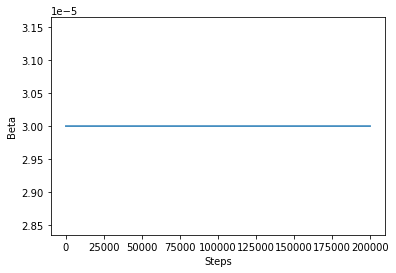

In [87]:
from lfp.train import BetaScheduler

TRAIN_STEPS = 200000
# 0.00001 so far works best for MAE - try lower - 0.00003 with a BETA accel of 10 so far works best, perfect encoder, nicely mapped planner
# recall 0.01 worked okay for probabilistic - proba still too unstable!
beta_sched = BetaScheduler('linear', 
                           beta=0.00003, 
                           beta_max=0.00003, 
                           max_steps=TRAIN_STEPS, 
                           cycles=90, 
                           duty_cycle=0.5
                           )

In [88]:
progbar = Progbar(TRAIN_STEPS, verbose=1, interval=0.5)
best_valid_loss = np.float('inf')

valid_inc = 20
save_inc = 1000

prev_grad_norm = np.float('inf')

In [89]:
from lfp.utils import save_weights, load_weights, load_optimizer_state

In [90]:
RESUME = True

In [91]:
run_name = "Tests"#"ALLB0.00003"
model_path = f'/content/drive/My Drive/Robotic Learning/LMP_test/{run_name}/'

if RESUME:
  run_id = str(np.load(model_path+'hyper_params.npz')['run_id'])
  wandb.init(project="learning-from-play_v2", id='12621l2h',  resume="must")
  load_weights(model_path, actor, encoder, planner)
  load_optimizer_state(optimizer, model_path, strategy, trainable_variables)
  print('Loaded model weights and optimiser state')
  t = wandb.run.step + valid_inc
else:
  wandb.init(project="learning-from-play_v2")
  wandb.run.name = run_name
  t = 0


planner_grad_norm_clipped,6e-05
valid_act_with_enc_loss_result,0.01849
valid_max_rotation_loss_result,5.06414
train_reg_loss_result,7.68261
encoder_grad_norm_clipped,0.00771
_runtime,279140
beta_result,3e-05
train_loss_result,0.01905
valid_rotation_loss_result,0.03184
train_act_with_plan_loss_result,0.02907
_step,125000


train_loss_result,█▄▁
valid_loss_result,█▅▁
valid_position_loss_result,█▄▁
valid_max_position_loss_result,█▁▃
valid_rotation_loss_result,█▄▁
valid_max_rotation_loss_result,█▂▁
valid_gripper_loss_result,▁█▇
actor_grad_norm,█▃▁
actor_grad_norm_clipped,█▃▁
train_act_with_enc_loss_result,█▄▁
train_act_with_plan_loss_result,█▅▁


Loaded model weights and optimiser state


In [92]:
# config = wandb.config

# # Hparams
# config.DEVICE = DEVICE
# config.WINDOW_SIZE = dl.window_size
# config.WINDOW_SHIFT = dl.window_shift
# config.LAYER_SIZE = LAYER_SIZE
# config.LATENT_DIM = LATENT_DIM
# config.GRIPPER_WEIGHT = GRIPPER_WEIGHT
# config.TRAIN_STEPS = TRAIN_STEPS
# config.beta_schedule = beta_sched.schedule
# config.beta_min = beta_sched.beta_min
# config.beta_max = beta_sched.beta_max
# config.PROBABILISTIC = PROBABILISTIC
# config.PROPRIOCEPTION = dl.proprioception
importlib.reload(lfp.utils)

<module 'lfp.utils' from '/content/learning_from_play/lfp/utils.py'>

In [93]:
from lfp.plotting import produce_cluster_fig, project_enc_and_plan, plot_to_image
from lfp.metric import log
v_it = iter(valid_dataset) #for the cluster fig, easier with a non distributed dataset



In [ ]:
while t < TRAIN_STEPS:
    start_time = time.time()
    beta = beta_sched.scheduler(t)
    x = next(train_dist_dataset)
    total_train_loss = distributed_train_step(x, beta, prev_grad_norm)
    
    if t % valid_inc == 0:  
        valid_x = next(valid_dist_dataset)
        if config['gcbc']:
          total_val_loss = distributed_test_step(valid_x, beta)
        else:
          total_val_loss, ze, zp = distributed_test_step(valid_x, beta)

        # validation plotting
        progbar.add(valid_inc, [('Train Loss', train_loss.result()), ('Validation Loss', valid_loss.result()), ('Time (s)', round(time.time() - start_time, 1))])


        wandb.log({'train_loss_result':log(train_loss),
                    'valid_loss_result':log(valid_loss),
                    'valid_position_loss_result':log(valid_position_loss),
                    'valid_max_position_loss_result':log(valid_max_position_loss),
                    'valid_rotation_loss_result':log(valid_rotation_loss),
                    'valid_max_rotation_loss_result':log(valid_max_rotation_loss),
                    'valid_gripper_loss_result':log(valid_gripper_loss),
                    'actor_grad_norm': log(actor_grad_norm),
                    'actor_grad_norm_clipped': log(actor_grad_norm_clipped),
                  },
                  step=t)
          
        if not config['gcbc']:
          wandb.log({
                      'train_act_with_enc_loss_result':log(train_act_with_enc_loss),
                      'train_act_with_plan_loss_result':log(train_act_with_plan_loss),
                      'train_reg_loss_result':log(train_reg_loss),
                      'valid_act_with_enc_loss_result':log(valid_act_with_enc_loss),
                      'valid_act_with_plan_loss_result':valid_act_with_plan_loss.result(),
                      'valid_reg_loss_result':log(valid_reg_loss),
                      'beta_result':beta,
                      'encoder_grad_norm': log(encoder_grad_norm),
                      'planner_grad_norm': log(planner_grad_norm),
                      'encoder_grad_norm_clipped': log(encoder_grad_norm_clipped),
                      'planner_grad_norm_clipped': log(planner_grad_norm_clipped),
                    },
                    step=t)
          

        prev_grad_norm = log(global_grad_norm)
          
    if t % save_inc == 0:
        save_weights(model_path, actor, config, dl, run_id,optimizer, encoder, planner)
        if not config['gcbc']:
          z_enc, z_plan = produce_cluster_fig(next(v_it), encoder, planner, TEST_DATA_PATHS[0], num_take=dl.batch_size)
          wandb.log({'z_enc':z_enc, 'z_plan':z_plan}, step=t)
          latent_fig = project_enc_and_plan(ze, zp)
          #latent_img = plot_to_image(latent_fig)

    t += 1

In [ ]:
# Use if deving locally - relatively painless
% cd lfp
! git pull
% cd ..